In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, callbacks

In [266]:
MODEL_NAME = "./treino/primeiro_treino"
PASTA_FOURIER = "data/fourier/"
SPS = 200

In [3]:
df = pd.read_csv('data/scores.csv')

In [4]:
df = df.sample(frac=1, random_state=200)

In [5]:
df_val = df.head(2700)
df_train = df.tail( df.shape[0]- 2700 )

In [267]:
def get_data(eeg):
    return np.load(PASTA_FOURIER+str(eeg)+".npy")


def get_start_end(row, pos, max_size):
    if pos == len(row['janelas']):
        return max_size, max_size

    j = row['janelas'].split(',')[0].split('-')
    return float(j[0])*2, float(j[1])*2

def score_data(row):
    data = get_data(row['eeg_id'])
    max_size = data.shape[0]
    scores = [] 
    j_pos = 0
    start, end = get_start_end(row, j_pos, max_size)

    for i in range(max_size):
        if end < i:
            j_pos += 1
            start, end = get_start_end(row, j_pos, max_size)

        if i >= start and i <= end:
            scores.append( [row['seizure_vote'],row['lpd_vote'],row['gpd_vote'],row['lrda_vote'],row['grda_vote'],row['other_vote'] ] )
        else:
            scores.append( [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] )


    return data, scores


In [268]:
def get_scored_tran_data():
    for i, row in df_train.iterrows():
        yield( score_data(row) )

def get_scored_val_data():
    for i, row in df_val.iterrows():
        yield( score_data(row) )


In [272]:
model = models.Sequential()
model.add(layers.Conv2D(2, (2, 2), activation='relu', input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 20)))
model.add(layers.Conv2D(4, (2, 2), activation='relu', input_shape=(20, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))


In [270]:
model.load_weights(MODEL_NAME)


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./treino/primeiro_treino

In [273]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 19, 199, 2)        10        
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 9, 9, 2)           0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 4)           36        
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 4, 4, 4)           0         
 ng2D)                                                           
                                                                 
 flatten_39 (Flatten)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 200)             

In [274]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.CategoricalCrossentropy()
)

In [275]:
train_data = tf.data.Dataset.from_generator(
        get_scored_train_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200), dtype=tf.float16),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float16)
        )
    )

val_data = tf.data.Dataset.from_generator(
        get_scored_val_data,
        output_signature = (
            tf.TensorSpec(shape=(None, 20, 200), dtype=tf.float16),
            tf.TensorSpec(shape=(None, 6), dtype=tf.float16)
        )
    )

In [276]:

history = model.fit(
    train_data,
    epochs=20,
    batch_size=500,
    shuffle=True,
    validatoin_data = val_data,
    verbose= 1,
    callbacks = [
        callbacks.EarlyStopping(monitor="val_loss", patience=2),
        callbacks.ModelCheckpoint(MODEL_NAME, save_best_only = True)
    ]
)

Epoch 1/2


    810/Unknown - 124s 151ms/step - loss: 1.1571

/home/cleverson/projetos/.kaggle/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py:229: RuntimeWarning: overflow encountered in cast
  result = np.asarray(value, dtype=dtype, order="C")


  17063/Unknown - 583s 34ms/step - loss: 719.4059WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
17063/17063 [==============================] - 583s 34ms/step - loss: 719.4059
Epoch 2/2
    7/17063 [..............................] - ETA: 5:34 - loss: 4259.6523

2024-03-20 22:11:36.932449: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1825908849203017035


17063/17063 [==============================] - 401s 24ms/step - loss: 8871.5859


In [278]:
model.save(MODEL_NAME)

INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


INFO:tensorflow:Assets written to: ./treino/primeiro_treino/assets


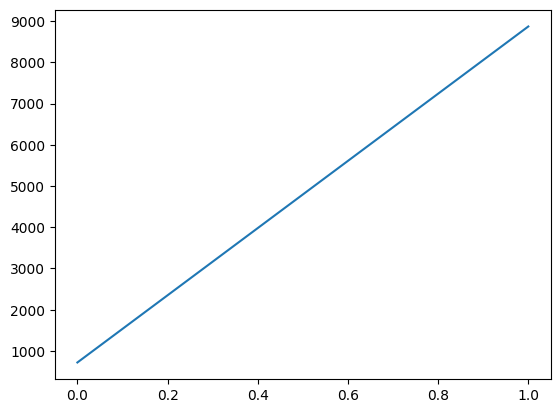

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])